In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess, cv2, json, os, sys, shutil, pyk4a, time
import numpy as np, matplotlib.pyplot as plt
from kinectacq.acquisition import start_recording
from kinectacq.paths import DATA_DIR, ensure_dir

### Set up recording location and duration info

In [3]:
import datetime

In [4]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timestamp

'2023-01-26_19-12-08'

In [5]:
filename_prefix = DATA_DIR / 'test_recording' / timestamp
recording_length = 10

In [6]:
ensure_dir(filename_prefix)

In [7]:
filename_prefix

PosixPath('/home/dattalab/code/kinectacq/data/test_recording/2023-01-26_19-12-08')

### Get camera information

In [9]:
!k4arecorder --list

Index:0	Serial:000621521712	Color:1.6.110	Depth:1.6.79


### Set up devices
- each k4a device needs to be configured
- multi-camera rigs need to set up the WiredSyncMode
    - Master = WiredSyncMode.MASTER
    - Subordinate = WiredSyncMode.SUBORDINATE
    - subordinate_delay_off_master_usec=640 (master samples every 900usec)

In [10]:
from pyk4a import (
    PyK4A,
    Config,
    ColorResolution,
    DepthMode,
    WiredSyncMode,
)

In [11]:
devices = {
    "master": {
        "id": 0,
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            #"synchronized_images_only": False,
            ###"wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": False,
        },
    }
}

### Testing

In [12]:
from multiprocessing import Process, Queue
from kinectacq.acquisition import capture_from_azure 

In [13]:
device_name = "master"

In [14]:
devices[device_name]["id"]

0

In [15]:
devices[device_name]["pyk4a_config"]

{'color_resolution': <ColorResolution.RES_720P: 1>,
 'depth_mode': <DepthMode.NFOV_UNBINNED: 2>}

In [16]:
k4a_obj = PyK4A(
    Config(**devices[device_name]["pyk4a_config"]),
    device_id=devices[device_name]["id"],
)

In [17]:
k4a_obj

In [18]:
k4a_obj.start()

In [19]:
capture = k4a_obj.get_capture()

In [20]:
capture.color.shape, capture.ir.shape, capture.depth.shape

((720, 1280, 4), (576, 640), (576, 640))

In [21]:
capture = k4a_obj.get_capture()
print(capture.color.shape, capture.ir.shape, capture.depth.shape)
print(capture._ir_timestamp_usec)

(720, 1280, 4) (576, 640) (576, 640)
333522


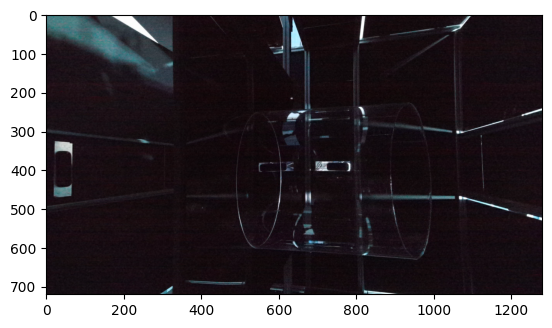

In [22]:
plt.imshow(capture.color[:,:,:3])

In [23]:
capture.color[:,:,:3].shape

(720, 1280, 3)

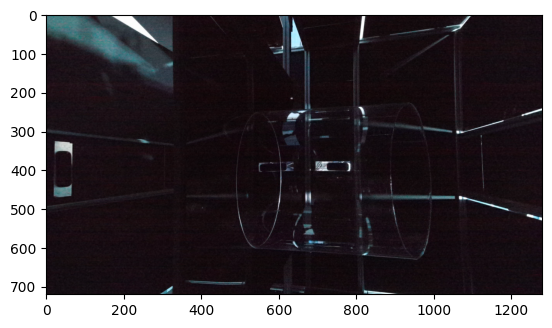

In [24]:
plt.imshow(capture.color)

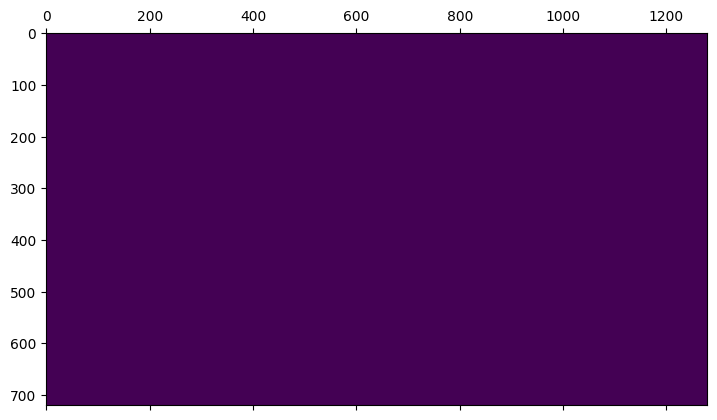

In [25]:
plt.matshow(capture.color[:,:,3])

In [26]:
capture.color.dtype

dtype('uint8')

In [27]:
capture._color_timestamp_usec

333555

In [28]:
capture._depth_timestamp_usec

333522

In [29]:
capture._ir_timestamp_usec

333522

In [30]:
capture.__dict__

{'_calibration': <pyk4a.calibration.Calibration at 0x7f2a483d7ee0>,
 '_capture_handle': <capsule object "pyk4a capture handle" at 0x7f2a07373810>,
 'thread_safe': True,
 '_color_format': <ImageFormat.COLOR_BGRA32: 3>,
 '_color': array([[[ 73, 127, 128, 255],
         [ 71, 125, 126, 255],
         [ 63, 120, 121, 255],
         ...,
         [ 33,  22,  24, 255],
         [ 31,  20,  22, 255],
         [ 29,  18,  20, 255]],
 
        [[ 79, 127, 129, 255],
         [ 79, 127, 129, 255],
         [ 76, 125, 127, 255],
         ...,
         [ 29,  18,  21, 255],
         [ 28,  17,  20, 255],
         [ 26,  15,  18, 255]],
 
        [[ 82, 127, 130, 255],
         [ 82, 127, 130, 255],
         [ 82, 127, 130, 255],
         ...,
         [ 27,  15,  21, 255],
         [ 27,  16,  19, 255],
         [ 27,  16,  19, 255]],
 
        ...,
 
        [[ 25,  18,  23, 255],
         [ 24,  17,  22, 255],
         [ 22,  15,  20, 255],
         ...,
         [ 26,  15,  23, 255],
         [

In [31]:
np.shape(capture.ir)

(576, 640)

In [32]:
capture.depth

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [33]:
capture.ir

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

/tmp/ipykernel_5091/3398262759.py:2: RuntimeWarning: divide by zero encountered in log
  ax1.matshow(np.log(capture.ir+1))


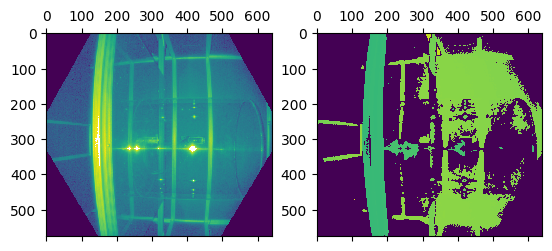

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.matshow(np.log(capture.ir+1))
ax2.matshow(np.log(capture.depth+1))

(array([2.70367e+05, 1.15050e+04, 8.63940e+04, 3.00000e+00, 3.61000e+02,
        3.00000e+00, 6.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([   0. ,  488.4,  976.8, 1465.2, 1953.6, 2442. , 2930.4, 3418.8,
        3907.2, 4395.6, 4884. ]),
 <BarContainer object of 10 artists>)

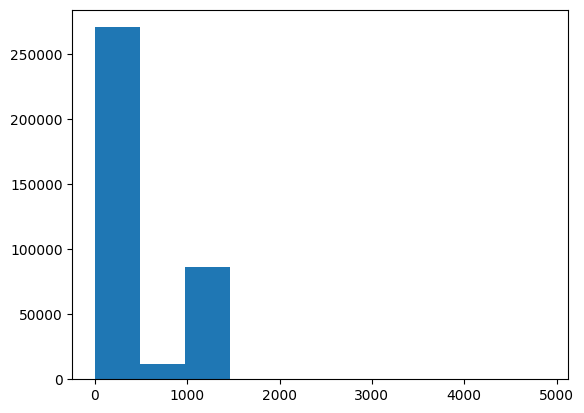

In [35]:
plt.hist(capture.depth.flatten())

In [36]:
depth = capture.depth

In [37]:
depth_pipe = None

In [38]:
from kinectacq.video_io import write_frames  

In [39]:
!ls /home/tim/Projects/azure_acquisition_template/data/test_recording/2022-02-07_14-24-15

ls: cannot access '/home/tim/Projects/azure_acquisition_template/data/test_recording/2022-02-07_14-24-15': No such file or directory


In [40]:
write_frames(
    filename_prefix / "test.depth.avi",
    depth.astype(np.uint8)[None, :, :],
    codec="ffv1",
    close_pipe=False,
    pipe=depth_pipe,
)

In [41]:
k4a_obj.stop()

In [42]:
import time
for i in range(10):
    capture = k4a_obj.get_capture()
    print(capture.color.shape, capture.ir.shape, capture.depth.shape)
    print(capture._ir_timestamp_usec*1e-6)
    time.sleep(1)

K4AException: Device is not opened

In [ ]:
capture._ir_timestamp_usec*1e-6

In [43]:
capture = k4a_obj.get_capture()
print(capture._ir_timestamp_usec)

K4AException: Device is not opened

In [44]:
capture = k4a_obj.get_capture()

K4AException: Device is not opened

In [45]:
capture.__dict__

{'_calibration': <pyk4a.calibration.Calibration at 0x7f2a483d7ee0>,
 '_capture_handle': <capsule object "pyk4a capture handle" at 0x7f2a07373810>,
 'thread_safe': True,
 '_color_format': <ImageFormat.COLOR_BGRA32: 3>,
 '_color': array([[[ 73, 127, 128, 255],
         [ 71, 125, 126, 255],
         [ 63, 120, 121, 255],
         ...,
         [ 33,  22,  24, 255],
         [ 31,  20,  22, 255],
         [ 29,  18,  20, 255]],
 
        [[ 79, 127, 129, 255],
         [ 79, 127, 129, 255],
         [ 76, 125, 127, 255],
         ...,
         [ 29,  18,  21, 255],
         [ 28,  17,  20, 255],
         [ 26,  15,  18, 255]],
 
        [[ 82, 127, 130, 255],
         [ 82, 127, 130, 255],
         [ 82, 127, 130, 255],
         ...,
         [ 27,  15,  21, 255],
         [ 27,  16,  19, 255],
         [ 27,  16,  19, 255]],
 
        ...,
 
        [[ 25,  18,  23, 255],
         [ 24,  17,  22, 255],
         [ 22,  15,  20, 255],
         ...,
         [ 26,  15,  23, 255],
         [

In [46]:
capture.color.shape#, capture.ir.shape, capture.depth.shape

(720, 1280, 4)

In [47]:
capture._color_timestamp_usec, capture._color_timestamp_usec*1e-6

(333555, 0.333555)

In [48]:
type(capture._color_timestamp_usec)

int

In [49]:
capture._color_system_timestamp_nsec

1315204238604

In [50]:
capture._color_timestamp_usec.astype('uint64')

AttributeError: 'int' object has no attribute 'astype'

In [51]:
type(time.time())

float

In [52]:
time.time_ns()

1674779569508032938

In [53]:
capture = k4a_obj.get_capture()

K4AException: Device is not opened

In [54]:
capture.ir

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [55]:
capture.ir is None

False

In [56]:
172484687609538
1645203935136079709

1645203935136079709